In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

Setup complete!


In [3]:
# Load FFS costs data for 2018
print("Loading FFS costs data...")

ffs_data = pd.read_excel(
    "../../../data/input/ffs_2018/FFS18.xlsx",
    skiprows=2,
    names=[
        "ssa", "state", "county_name", "parta_enroll",
        "parta_reimb", "parta_percap", "parta_reimb_unadj",
        "parta_percap_unadj", "parta_ime", "parta_dsh",
        "parta_gme", "partb_enroll",
        "partb_reimb", "partb_percap"
    ],
    na_values="*"
)

# Clean and prepare FFS data
final_ffs_costs = (
    ffs_data[['ssa', 'state', 'county_name', 'parta_enroll', 'parta_reimb',
              'partb_enroll', 'partb_reimb']]
    .assign(
        year=2018,
        ssa=lambda x: pd.to_numeric(x['ssa'], errors='coerce'),
        mean_risk=np.nan
    )
)

# Convert numeric columns
numeric_cols = ['parta_enroll', 'parta_reimb', 'partb_enroll', 'partb_reimb']
for col in numeric_cols:
    final_ffs_costs[col] = pd.to_numeric(
        final_ffs_costs[col].astype(str).str.replace(',', ''), 
        errors='coerce'
    )

# Fill NaN with 0 for enrollment and reimbursement
final_ffs_costs[numeric_cols] = final_ffs_costs[numeric_cols].fillna(0)

# Calculate average FFS cost per capita (following the R code logic exactly)
def calculate_avg_ffscost(row):
    parta_enroll = row['parta_enroll']
    partb_enroll = row['partb_enroll']
    parta_reimb = row['parta_reimb']
    partb_reimb = row['partb_reimb']
    
    if parta_enroll == 0 and partb_enroll == 0:
        return 0
    elif parta_enroll == 0 and partb_enroll > 0:
        return partb_reimb / partb_enroll
    elif parta_enroll > 0 and partb_enroll == 0:
        return parta_reimb / parta_enroll
    elif parta_enroll > 0 and partb_enroll > 0:
        return (parta_reimb / parta_enroll) + (partb_reimb / partb_enroll)
    else:
        return np.nan

final_ffs_costs['avg_ffscost'] = final_ffs_costs.apply(calculate_avg_ffscost, axis=1)

# Also calculate total FFS costs and total beneficiaries
final_ffs_costs['ffs_costs'] = final_ffs_costs['parta_reimb'] + final_ffs_costs['partb_reimb']
final_ffs_costs['total_benef'] = final_ffs_costs['parta_enroll'] + final_ffs_costs['partb_enroll']

print(f"FFS data loaded: {len(final_ffs_costs):,} records")
print(f"\nAverage FFS cost statistics:")
print(final_ffs_costs['avg_ffscost'].describe())
print(f"\nRecords with zero FFS cost: {(final_ffs_costs['avg_ffscost'] == 0).sum()}")
print(f"Records with missing FFS cost: {final_ffs_costs['avg_ffscost'].isna().sum()}")

final_ffs_costs.head(10)

Loading FFS costs data...
FFS data loaded: 3,224 records

Average FFS cost statistics:
count    3224.00
mean     9170.41
std      1622.11
min         0.00
25%      8390.77
50%      9072.62
75%      9898.37
max     18241.12
Name: avg_ffscost, dtype: float64

Records with zero FFS cost: 3
Records with missing FFS cost: 0


,ssa,state,county_name,parta_enroll,parta_reimb,partb_enroll,partb_reimb,year,mean_risk,avg_ffscost,ffs_costs,total_benef
0,1010.00,ALABAMA,BALDWIN,28649.00,88505332.00,25551.00,132300296.00,2018,NaN,8267.19,220805628.00,54200.00
1,1020.00,ALABAMA,BARBOUR,3292.00,13042065.00,3041.00,15543046.00,2018,NaN,9072.91,28585111.00,6333.00
2,1030.00,ALABAMA,BIBB,2220.00,8935838.00,1944.00,9702178.00,2018,NaN,9015.98,18638016.00,4164.00
3,1040.00,ALABAMA,BLOUNT,4685.00,15550904.00,4164.00,21517760.00,2018,NaN,8486.87,37068664.00,8849.00
4,1050.00,ALABAMA,BULLOCK,798.00,3210417.00,728.00,2882518.00,2018,NaN,7982.58,6092935.00,1526.00
5,1060.00,ALABAMA,BUTLER,3532.00,12400172.00,3297.00,16477678.00,2018,NaN,8508.59,28877850.00,6829.00
6,1070.00,ALABAMA,CALHOUN,20497.00,77760427.00,18510.00,93580766.00,2018,NaN,8849.43,171341193.00,39007.00
7,1080.00,ALABAMA,CHAMBERS,6304.00,21735468.00,5857.00,25120987.00,2018,NaN,7736.94,46856455.00,12161.00
8,1090.00,ALABAMA,CHEROKEE,3871.00,14313005.00,3628.00,18535383.00,2018,NaN,8806.48,32848388.00,7499.00
9,1100.00,ALABAMA,CHILTON,3618.00,12503563.00,3198.00,17772332.00,2018,NaN,9013.26,30275895.00,6816.00


In [4]:
# Load 2018 plan data with bid information
print("Loading 2018 plan data...")
plan_data_2018 = pd.read_csv("../../../data/output/ma_data_enhanced_2018.csv")
plan_data_2018['year'] = 2018

# Load HHI data calculated earlier
hhi_2018 = pd.read_csv("../../../data/output/hhi_by_county_year.csv")
hhi_2018 = hhi_2018[hhi_2018['year'] == 2018].copy()

print(f"Plan data 2018: {len(plan_data_2018):,} records")
print(f"HHI data 2018: {len(hhi_2018):,} counties")

# Check what columns are in plan_data_2018
print("\nColumns in plan data 2018:")
print(plan_data_2018.columns.tolist())

# Display sample
print("\nSample of plan data:")
plan_data_2018.head()

Loading 2018 plan data...
Plan data 2018: 87,708 records
HHI data 2018: 2,996 counties

Columns in plan data 2018:
['contractid', 'planid', 'fips', 'year', 'state_plan', 'county_plan', 'org_type_plan', 'plan_type_plan', 'partd', 'snp', 'eghp_plan', 'org_name_plan', 'org_marketing_name', 'plan_name', 'parent_org', 'contract_date', 'enrollment', 'state_sa', 'county_sa', 'org_name_sa', 'org_type_sa', 'plan_type_sa', 'partial', 'eghp_sa', 'ssa', 'notes', 'state', 'county', 'premium', 'premium_partc', 'premium_partd_basic', 'premium_partd_supp', 'premium_partd_total', 'partd_deductible', 'year_landscape', 'riskscore_partc', 'payment_partc', 'rebate_partc', 'year_rr', 'payment_partd', 'directsubsidy_partd', 'reinsurance_partd', 'costsharing_partd', 'riskscore_partd', 'basic_premium', 'bid']

Sample of plan data:


,contractid,planid,fips,year,state_plan,county_plan,org_type_plan,plan_type_plan,partd,snp,eghp_plan,org_name_plan,org_marketing_name,plan_name,parent_org,contract_date,enrollment,state_sa,county_sa,org_name_sa,org_type_sa,plan_type_sa,partial,eghp_sa,ssa,notes,state,county,premium,premium_partc,premium_partd_basic,premium_partd_supp,premium_partd_total,partd_deductible,year_landscape,riskscore_partc,payment_partc,rebate_partc,year_rr,payment_partd,directsubsidy_partd,reinsurance_partd,costsharing_partd,riskscore_partd,basic_premium,bid
0,H0022,1,39023.00,2018,OH,Clark,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,622.00,OH,Clark,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36110.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H0022,1,39035.00,2018,OH,Cuyahoga,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,3657.00,OH,Cuyahoga,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36170.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H0022,1,39051.00,2018,OH,Fulton,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,126.00,OH,Fulton,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36260.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H0022,1,39055.00,2018,OH,Geauga,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,80.00,OH,Geauga,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36280.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H0022,1,39057.00,2018,OH,Greene,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,601.00,OH,Greene,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36290.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check for bid-related columns
bid_related = [col for col in plan_data_2018.columns if any(x in col.lower() for x in ['bid', 'premium', 'payment'])]
print("Bid-related columns found:", bid_related)

# Common column names to check
possible_bid_cols = ['bid', 'premium', 'ma_rate', 'payment_rate', 'plan_payment', 'monthly_premium']

bid_col = None
for col in possible_bid_cols:
    if col in plan_data_2018.columns:
        bid_col = col
        print(f"\nUsing '{bid_col}' as the bid column")
        break

if bid_col is None:
    print("\nWARNING: No standard bid column found!")
    print("Available columns:", plan_data_2018.columns.tolist())
    print("\nPlease manually specify the bid column name:")
    # Uncomment and set manually if needed:
    # bid_col = 'your_bid_column_name'
else:
    print(f"\nBid column statistics:")
    print(plan_data_2018[bid_col].describe())

Bid-related columns found: ['premium', 'premium_partc', 'premium_partd_basic', 'premium_partd_supp', 'premium_partd_total', 'payment_partc', 'payment_partd', 'basic_premium', 'bid']

Using 'bid' as the bid column

Bid column statistics:
count   76248.00
mean      755.39
std       134.02
min       191.77
25%       697.28
50%       756.72
75%       821.07
max      1584.73
Name: bid, dtype: float64


In [6]:
# First, merge plan data with HHI
print("Merging plan data with HHI...")
analysis_data = plan_data_2018.merge(
    hhi_2018[['fips', 'hhi']],
    on='fips',
    how='left'
)

print(f"After HHI merge: {len(analysis_data):,} records")
print(f"Missing HHI: {analysis_data['hhi'].isna().sum():,}")

# Check if we have SSA code in the plan data
if 'ssa' in analysis_data.columns:
    print("\nSSA code found in plan data - will merge on SSA and year")
    merge_keys = ['ssa', 'year']
    
    # Merge with FFS costs (drop 'state' to avoid conflicts)
    ffs_merge = final_ffs_costs.drop(columns=['state'], errors='ignore')
    
    analysis_data = analysis_data.merge(
        ffs_merge[['ssa', 'year', 'avg_ffscost', 'ffs_costs', 'parta_enroll', 
                   'partb_enroll', 'total_benef', 'county_name']],
        on=merge_keys,
        how='left'
    )
else:
    print("\nNo SSA code in plan data - attempting FIPS merge")
    # Create FIPS from SSA if needed
    # Note: You may need to create a crosswalk between FIPS and SSA
    # For now, we'll try to match on county name and state
    
    analysis_data = analysis_data.merge(
        final_ffs_costs[['county_name', 'state', 'year', 'avg_ffscost', 
                        'ffs_costs', 'parta_enroll', 'partb_enroll', 
                        'total_benef', 'ssa']],
        on=['county_name', 'state', 'year'] if 'county_name' in analysis_data.columns else ['year'],
        how='left'
    )

print(f"\nAfter FFS merge: {len(analysis_data):,} records")
print(f"Missing avg_ffscost: {analysis_data['avg_ffscost'].isna().sum():,}")
print(f"Missing HHI: {analysis_data['hhi'].isna().sum():,}")

# Display merge results
print(f"\nAverage FFS cost per capita: ${analysis_data['avg_ffscost'].mean():.2f}")
print(f"Median FFS cost per capita: ${analysis_data['avg_ffscost'].median():.2f}")

analysis_data.head()

Merging plan data with HHI...
After HHI merge: 87,708 records
Missing HHI: 937

SSA code found in plan data - will merge on SSA and year

After FFS merge: 87,708 records
Missing avg_ffscost: 411
Missing HHI: 937

Average FFS cost per capita: $9228.47
Median FFS cost per capita: $9149.24


,contractid,planid,fips,year,state_plan,county_plan,org_type_plan,plan_type_plan,partd,snp,eghp_plan,org_name_plan,org_marketing_name,plan_name,parent_org,contract_date,enrollment,state_sa,county_sa,org_name_sa,org_type_sa,plan_type_sa,partial,eghp_sa,ssa,notes,state,county,premium,premium_partc,premium_partd_basic,premium_partd_supp,premium_partd_total,partd_deductible,year_landscape,riskscore_partc,payment_partc,rebate_partc,year_rr,payment_partd,directsubsidy_partd,reinsurance_partd,costsharing_partd,riskscore_partd,basic_premium,bid,hhi,avg_ffscost,ffs_costs,parta_enroll,partb_enroll,total_benef,county_name
0,H0022,1,39023.00,2018,OH,Clark,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,622.00,OH,Clark,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36110.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,903.83,9622.58,140676849.00,15753.00,13689.00,29442.00,CLARK
1,H0022,1,39035.00,2018,OH,Cuyahoga,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,3657.00,OH,Cuyahoga,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36170.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1249.03,9664.55,1247130443.00,140616.00,119042.00,259658.00,CUYAHOGA
2,H0022,1,39051.00,2018,OH,Fulton,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,126.00,OH,Fulton,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36260.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1397.96,8457.29,51004569.00,6379.00,5776.00,12155.00,FULTON
3,H0022,1,39055.00,2018,OH,Geauga,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,80.00,OH,Geauga,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36280.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.70,8208.34,85046698.00,11294.00,9735.00,21029.00,GEAUGA
4,H0022,1,39057.00,2018,OH,Greene,Demo,Medicare-Medicaid Plan HMO/HMOPOS,Yes,No,No,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Buckeye Health Plan - MyCare Ohio,Buckeye Health Plan - MyCare Ohio (Medicare-Medicaid Plan),Centene Corporation,05/01/2014 0:00:00,601.00,OH,Greene,"BUCKEYE COMMUNITY HEALTH PLAN, INC.",Demo,Medicare-Medicaid Plan HMO/HMOPOS,NaN,NaN,36290.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2098.76,9085.58,116367635.00,13834.00,12036.00,25870.00,GREENE


In [7]:
# Defining treatment groups

# Calculate HHI percentiles
hhi_33 = hhi_2018['hhi'].quantile(0.33)
hhi_66 = hhi_2018['hhi'].quantile(0.66)

print("="*70)
print("DEFINING TREATMENT GROUPS")
print("="*70)
print(f"\nHHI 33rd percentile (competitive threshold): {hhi_33:.2f}")
print(f"HHI 66th percentile (uncompetitive threshold): {hhi_66:.2f}")

# Create treatment variable at county level
hhi_treatment = hhi_2018.copy()
hhi_treatment['competitive'] = (hhi_treatment['hhi'] <= hhi_33).astype(int)
hhi_treatment['uncompetitive'] = (hhi_treatment['hhi'] >= hhi_66).astype(int)

# Keep only competitive or uncompetitive markets (drop middle third)
hhi_treatment = hhi_treatment[
    (hhi_treatment['competitive'] == 1) | (hhi_treatment['uncompetitive'] == 1)
].copy()

# Create binary treatment variable (1 = uncompetitive, 0 = competitive)
hhi_treatment['treatment'] = hhi_treatment['uncompetitive']

print(f"\nCompetitive markets (control, treatment=0): {hhi_treatment['competitive'].sum():,}")
print(f"Uncompetitive markets (treatment=1): {hhi_treatment['uncompetitive'].sum():,}")
print(f"Total markets in analysis: {len(hhi_treatment):,}")

# Merge treatment assignment back to analysis data
analysis_data = analysis_data.merge(
    hhi_treatment[['fips', 'treatment', 'competitive', 'uncompetitive']],
    on='fips',
    how='inner'  # Only keep counties in treatment or control
)

print(f"\nAnalysis data after treatment assignment: {len(analysis_data):,} records")
print(f"Plans in competitive markets: {analysis_data[analysis_data['treatment']==0].shape[0]:,}")
print(f"Plans in uncompetitive markets: {analysis_data[analysis_data['treatment']==1].shape[0]:,}")

DEFINING TREATMENT GROUPS

HHI 33rd percentile (competitive threshold): 2143.04
HHI 66th percentile (uncompetitive threshold): 3572.44

Competitive markets (control, treatment=0): 989
Uncompetitive markets (treatment=1): 1,019
Total markets in analysis: 2,008

Analysis data after treatment assignment: 62,548 records
Plans in competitive markets: 48,983
Plans in uncompetitive markets: 13,565


In [9]:
# Create FFS cost quartiles and dummies
# Aggregate to county level first
print("Creating county-level dataset...")

# Determine which columns to aggregate
agg_dict = {
    'avg_ffscost': 'first',
    'ffs_costs': 'first',
    'total_benef': 'first',
    'treatment': 'first',
    'hhi': 'first'
}

# Add bid column if it exists
if bid_col and bid_col in analysis_data.columns:
    agg_dict[bid_col] = 'mean'  # Average bid across plans in county

# Add ssa if it exists
if 'ssa' in analysis_data.columns:
    agg_dict['ssa'] = 'first'

county_level = analysis_data.groupby('fips').agg(agg_dict).reset_index()

# Remove missing values
county_level = county_level.dropna(subset=['avg_ffscost', bid_col if bid_col else 'fips'])

print(f"Counties with valid data: {len(county_level):,}")

# Create quartiles based on avg_ffscost
county_level['ffs_quartile'] = pd.qcut(
    county_level['avg_ffscost'], 
    q=4, 
    labels=['Q1', 'Q2', 'Q3', 'Q4'],
    duplicates='drop'
)

# Create dummy variables for quartiles
for i, q in enumerate(['Q1', 'Q2', 'Q3', 'Q4'], 1):
    county_level[f'ffs_q{i}'] = (county_level['ffs_quartile'] == q).astype(int)

print("\n" + "="*70)
print("FFS COST QUARTILES")
print("="*70)
quartile_summary = county_level.groupby('ffs_quartile')['avg_ffscost'].describe()
print(quartile_summary)

print(f"\nQuartile distribution:")
print(county_level['ffs_quartile'].value_counts().sort_index())

# Merge quartiles back to analysis data
analysis_data = analysis_data.merge(
    county_level[['fips', 'ffs_quartile', 'ffs_q1', 'ffs_q2', 'ffs_q3', 'ffs_q4']],
    on='fips',
    how='left'
)

print(f"\nAnalysis data with quartiles: {len(analysis_data):,} records")

Creating county-level dataset...
Counties with valid data: 1,976

FFS COST QUARTILES
              count     mean     std     min      25%      50%      75%  \
ffs_quartile                                                              
Q1           494.00  7417.20 1339.74    0.00  7296.73  7903.97  8220.08   
Q2           494.00  8754.04  194.95 8410.46  8578.73  8781.10  8917.39   
Q3           494.00  9450.13  215.64 9081.63  9274.03  9438.14  9630.35   
Q4           494.00 10929.48 1078.85 9837.59 10192.17 10610.65 11384.70   

                  max  
ffs_quartile           
Q1            8409.13  
Q2            9075.39  
Q3            9833.79  
Q4           17984.80  

Quartile distribution:
ffs_quartile
Q1    494
Q2    494
Q3    494
Q4    494
Name: count, dtype: int64

Analysis data with quartiles: 62,548 records


QUESTION 5: Average Bid by Market Type

Average Bid Statistics:
            mean    std  count
treatment                     
0         759.44 105.18    988
1         780.36  61.05    988

Market Type                        Average Bid
--------------------------------------------------
Competitive (treatment=0)      $        759.44
Uncompetitive (treatment=1)    $        780.36
--------------------------------------------------
Difference (Uncompetitive - Competitive) $         20.92


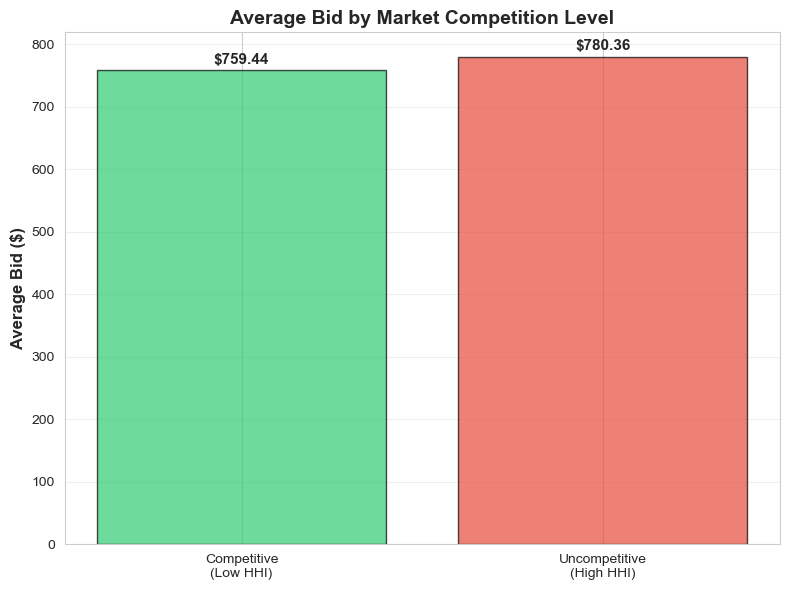


Plot saved to: ../../../data/output/question1_avg_bid.png


In [10]:
# Question 5: Average Bid by Market Type
print("="*70)
print("QUESTION 5: Average Bid by Market Type")
print("="*70)

if bid_col and bid_col in county_level.columns:
    # Calculate average bid by treatment group
    avg_bids = county_level.groupby('treatment')[bid_col].agg(['mean', 'std', 'count'])
    
    print(f"\nAverage Bid Statistics:")
    print(avg_bids)
    
    competitive_bid = avg_bids.loc[0, 'mean']
    uncompetitive_bid = avg_bids.loc[1, 'mean']
    difference = uncompetitive_bid - competitive_bid
    
    print(f"\n{'Market Type':<30} {'Average Bid':>15}")
    print("-" * 50)
    print(f"{'Competitive (treatment=0)':<30} ${competitive_bid:>14.2f}")
    print(f"{'Uncompetitive (treatment=1)':<30} ${uncompetitive_bid:>14.2f}")
    print("-" * 50)
    print(f"{'Difference (Uncompetitive - Competitive)':<30} ${difference:>14.2f}")
    
    # Visual comparison
    fig, ax = plt.subplots(figsize=(8, 6))
    treatment_labels = ['Competitive\n(Low HHI)', 'Uncompetitive\n(High HHI)']
    colors = ['#2ecc71', '#e74c3c']
    
    ax.bar(treatment_labels, [competitive_bid, uncompetitive_bid], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Average Bid ($)', fontweight='bold', fontsize=12)
    ax.set_title('Average Bid by Market Competition Level', fontweight='bold', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (label, value) in enumerate(zip(treatment_labels, [competitive_bid, uncompetitive_bid])):
        ax.text(i, value + 10, f'${value:.2f}', ha='center', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.savefig("../../../data/output/question1_avg_bid.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nPlot saved to: ../../../data/output/question1_avg_bid.png")
else:
    print(f"ERROR: Bid column '{bid_col}' not found in data")
    print("Available columns:", county_level.columns.tolist())

QUESTION 6: Average Bid by Treatment Group and FFS Quartile

Detailed Table:
                         mean    std  count
treatment ffs_quartile                     
0         Q1           717.79 164.06    282
          Q2           782.60  59.97    255
          Q3           770.04  57.04    232
          Q4           774.87  67.27    219
1         Q1           792.13  73.47    212
          Q2           780.68  61.93    239
          Q3           771.05  56.31    262
          Q4           779.87  52.22    275

Average Bid by FFS Quartile and Treatment Status
              Competitive (0)  Uncompetitive (1)
ffs_quartile                                    
Q1                     717.79             792.13
Q2                     782.60             780.68
Q3                     770.04             771.05
Q4                     774.87             779.87

With Differences:
              Competitive (0)  Uncompetitive (1)  Difference (1-0)
ffs_quartile                                         

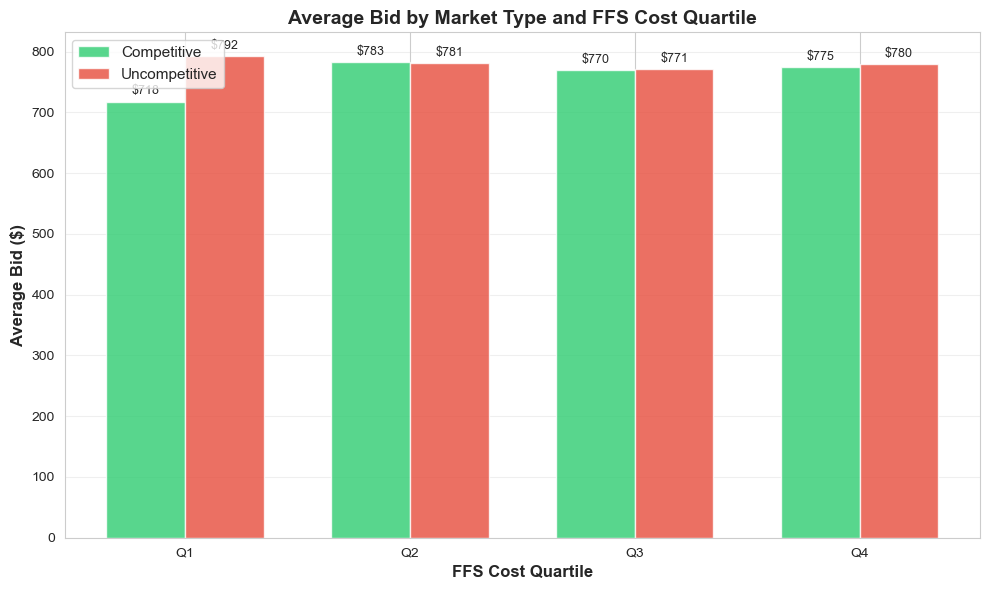


Plot saved to: ../../../data/output/question2_bid_by_quartile.png
Table saved to: ../../../data/output/question2_bid_table.csv


In [11]:
# Question 6: Average Bid by treatment and FFS quartile
print("="*70)
print("QUESTION 6: Average Bid by Treatment Group and FFS Quartile")
print("="*70)

if bid_col and bid_col in county_level.columns:
    # Create table of average bids
    bid_table = county_level.groupby(['treatment', 'ffs_quartile'])[bid_col].agg(['mean', 'std', 'count'])
    
    print("\nDetailed Table:")
    print(bid_table)
    
    # Pivot for cleaner display
    bid_pivot = county_level.pivot_table(
        values=bid_col,
        index='ffs_quartile',
        columns='treatment',
        aggfunc='mean'
    )
    bid_pivot.columns = ['Competitive (0)', 'Uncompetitive (1)']
    
    print("\n" + "="*70)
    print("Average Bid by FFS Quartile and Treatment Status")
    print("="*70)
    print(bid_pivot.round(2))
    
    # Calculate difference
    bid_pivot['Difference (1-0)'] = bid_pivot['Uncompetitive (1)'] - bid_pivot['Competitive (0)']
    print("\nWith Differences:")
    print(bid_pivot.round(2))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(bid_pivot.index))
    width = 0.35
    
    competitive = bid_pivot['Competitive (0)'].values
    uncompetitive = bid_pivot['Uncompetitive (1)'].values
    
    rects1 = ax.bar(x - width/2, competitive, width, label='Competitive', color='#2ecc71', alpha=0.8)
    rects2 = ax.bar(x + width/2, uncompetitive, width, label='Uncompetitive', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('FFS Cost Quartile', fontweight='bold', fontsize=12)
    ax.set_ylabel('Average Bid ($)', fontweight='bold', fontsize=12)
    ax.set_title('Average Bid by Market Type and FFS Cost Quartile', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(bid_pivot.index)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'${height:.0f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.savefig("../../../data/output/question2_bid_by_quartile.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save table
    bid_pivot.to_csv("../../../data/output/question2_bid_table.csv")
    print(f"\nPlot saved to: ../../../data/output/question2_bid_by_quartile.png")
    print(f"Table saved to: ../../../data/output/question2_bid_table.csv")
else:
    print(f"ERROR: Bid column '{bid_col}' not found")

In [12]:
# Helper functions for ATE estimation
def nearest_neighbor_matching_inverse_variance(data, outcome_col, treatment_col, covariate_cols):
    """
    1-to-1 Nearest Neighbor Matching with Inverse Variance Distance
    """
    treated = data[data[treatment_col] == 1].copy().reset_index(drop=True)
    control = data[data[treatment_col] == 0].copy().reset_index(drop=True)
    
    # Calculate variance for each covariate
    variances = data[covariate_cols].var()
    
    # Prevent division by zero
    variances = variances.replace(0, 1e-10)
    
    # Standardize covariates by inverse variance
    treated_X = treated[covariate_cols].values / np.sqrt(variances.values)
    control_X = control[covariate_cols].values / np.sqrt(variances.values)
    
    # Find nearest neighbor for each treated unit
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control_X)
    distances, indices = nbrs.kneighbors(treated_X)
    
    # Get matched pairs
    treated_outcomes = treated[outcome_col].values
    matched_control_outcomes = control[outcome_col].iloc[indices.flatten()].values
    
    # Calculate ATE
    ate = np.mean(treated_outcomes - matched_control_outcomes)
    se = np.std(treated_outcomes - matched_control_outcomes) / np.sqrt(len(treated_outcomes))
    
    return ate, se, len(treated), indices


def nearest_neighbor_matching_mahalanobis(data, outcome_col, treatment_col, covariate_cols):
    """
    1-to-1 Nearest Neighbor Matching with Mahalanobis Distance
    """
    treated = data[data[treatment_col] == 1].copy().reset_index(drop=True)
    control = data[data[treatment_col] == 0].copy().reset_index(drop=True)
    
    # Calculate covariance matrix
    cov_matrix = data[covariate_cols].cov()
    
    # Handle singular matrix
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        inv_cov_matrix = np.linalg.pinv(cov_matrix)
    
    treated_X = treated[covariate_cols].values
    control_X = control[covariate_cols].values
    
    # Calculate Mahalanobis distance for each treated unit
    matched_indices = []
    for t_x in treated_X:
        distances = []
        for c_x in control_X:
            try:
                dist = mahalanobis(t_x, c_x, inv_cov_matrix)
            except:
                dist = np.linalg.norm(t_x - c_x)  # Fallback to Euclidean
            distances.append(dist)
        matched_indices.append(np.argmin(distances))
    
    # Get matched pairs
    treated_outcomes = treated[outcome_col].values
    matched_control_outcomes = control[outcome_col].iloc[matched_indices].values
    
    # Calculate ATE
    ate = np.mean(treated_outcomes - matched_control_outcomes)
    se = np.std(treated_outcomes - matched_control_outcomes) / np.sqrt(len(treated_outcomes))
    
    return ate, se, len(treated), matched_indices


def inverse_propensity_weighting(data, outcome_col, treatment_col, covariate_cols):
    """
    Inverse Propensity Score Weighting
    """
    # Estimate propensity scores
    X = data[covariate_cols].values
    y = data[treatment_col].values
    
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    propensity_scores = lr.predict_proba(X)[:, 1]
    
    # Clip propensity scores to avoid extreme weights
    propensity_scores = np.clip(propensity_scores, 0.01, 0.99)
    
    # Calculate weights
    weights = np.where(
        data[treatment_col] == 1,
        1 / propensity_scores,
        1 / (1 - propensity_scores)
    )
    
    # Calculate weighted means
    treated_mask = data[treatment_col] == 1
    control_mask = data[treatment_col] == 0
    
    treated_weighted_mean = np.average(
        data.loc[treated_mask, outcome_col],
        weights=weights[treated_mask]
    )
    
    control_weighted_mean = np.average(
        data.loc[control_mask, outcome_col],
        weights=weights[control_mask]
    )
    
    ate = treated_weighted_mean - control_weighted_mean
    
    # Calculate standard error (simplified)
    treated_outcomes = data.loc[treated_mask, outcome_col].values
    control_outcomes = data.loc[control_mask, outcome_col].values
    
    var_treated = np.var(treated_outcomes * weights[treated_mask]) / treated_mask.sum()
    var_control = np.var(control_outcomes * weights[control_mask]) / control_mask.sum()
    se = np.sqrt(var_treated + var_control)
    
    return ate, se, propensity_scores


def linear_regression_ate(data, outcome_col, treatment_col, covariate_cols):
    """
    Linear Regression with Interactions
    """
    # Create design matrix with treatment and covariates
    X = data[[treatment_col] + covariate_cols].copy()
    
    # Add interactions between treatment and covariates
    for cov in covariate_cols:
        X[f'{treatment_col}_x_{cov}'] = X[treatment_col] * X[cov]
    
    y = data[outcome_col].values
    
    # Fit regression
    lr = LinearRegression()
    lr.fit(X, y)
    
    # ATE is the coefficient on treatment
    ate = lr.coef_[0]
    
    # Calculate standard error
    y_pred = lr.predict(X)
    residuals = y - y_pred
    mse = np.mean(residuals**2)
    
    # Standard error of coefficient (simplified)
    X_matrix = X.values
    try:
        var_coef = mse * np.linalg.inv(X_matrix.T @ X_matrix)
        se = np.sqrt(var_coef[0, 0])
    except:
        se = np.nan
    
    return ate, se, lr


print("Helper functions defined successfully!")

Helper functions defined successfully!


In [13]:
# Question 7: ATE Estimation
print("="*70)
print("QUESTION 3: Average Treatment Effects (ATE)")
print("="*70)

# Prepare data for estimation
estimation_data = county_level.dropna(subset=[bid_col, 'ffs_q1', 'ffs_q2', 'ffs_q3', 'ffs_q4'])

print(f"\nEstimation sample size: {len(estimation_data):,} counties")
print(f"  Treated (uncompetitive): {(estimation_data['treatment']==1).sum():,}")
print(f"  Control (competitive): {(estimation_data['treatment']==0).sum():,}")

# Covariates (FFS quartile dummies - use Q2, Q3, Q4 to avoid collinearity)
quartile_cols = ['ffs_q2', 'ffs_q3', 'ffs_q4']

print("\n" + "-"*70)
print("Estimating treatment effects...")
print("-"*70)

# Method 1: Nearest Neighbor with Inverse Variance
print("\n1. Nearest Neighbor Matching (Inverse Variance)...")
ate_nn_iv, se_nn_iv, n_treated_iv, _ = nearest_neighbor_matching_inverse_variance(
    estimation_data, bid_col, 'treatment', quartile_cols
)
print(f"   ATE: ${ate_nn_iv:.2f} (SE: ${se_nn_iv:.2f})")
print(f"   Treated units matched: {n_treated_iv}")

# Method 2: Nearest Neighbor with Mahalanobis
print("\n2. Nearest Neighbor Matching (Mahalanobis)...")
ate_nn_maha, se_nn_maha, n_treated_maha, _ = nearest_neighbor_matching_mahalanobis(
    estimation_data, bid_col, 'treatment', quartile_cols
)
print(f"   ATE: ${ate_nn_maha:.2f} (SE: ${se_nn_maha:.2f})")
print(f"   Treated units matched: {n_treated_maha}")

# Method 3: Inverse Propensity Weighting
print("\n3. Inverse Propensity Weighting...")
ate_ipw, se_ipw, ps_scores = inverse_propensity_weighting(
    estimation_data, bid_col, 'treatment', quartile_cols
)
print(f"   ATE: ${ate_ipw:.2f} (SE: ${se_ipw:.2f})")
print(f"   Propensity score range: [{ps_scores.min():.3f}, {ps_scores.max():.3f}]")

# Method 4: Linear Regression
print("\n4. Linear Regression with Interactions...")
ate_reg, se_reg, reg_model = linear_regression_ate(
    estimation_data, bid_col, 'treatment', quartile_cols
)
print(f"   ATE: ${ate_reg:.2f} (SE: ${se_reg:.2f})")

# Create summary table
ate_results = pd.DataFrame({
    'Method': [
        'NN Matching (Inverse Variance)',
        'NN Matching (Mahalanobis)',
        'Inverse Propensity Weighting',
        'Linear Regression'
    ],
    'ATE': [ate_nn_iv, ate_nn_maha, ate_ipw, ate_reg],
    'SE': [se_nn_iv, se_nn_maha, se_ipw, se_reg]
})

ate_results['CI_Lower'] = ate_results['ATE'] - 1.96 * ate_results['SE']
ate_results['CI_Upper'] = ate_results['ATE'] + 1.96 * ate_results['SE']

print("\n" + "="*70)
print("SUMMARY OF TREATMENT EFFECTS")
print("="*70)
print(ate_results.to_string(index=False))

# Save results
ate_results.to_csv("../../../data/output/question3_ate_results.csv", index=False)
print(f"\nResults saved to: ../../../data/output/question3_ate_results.csv")

QUESTION 3: Average Treatment Effects (ATE)

Estimation sample size: 1,976 counties
  Treated (uncompetitive): 988
  Control (competitive): 988

----------------------------------------------------------------------
Estimating treatment effects...
----------------------------------------------------------------------

1. Nearest Neighbor Matching (Inverse Variance)...
   ATE: $27.67 (SE: $2.02)
   Treated units matched: 988

2. Nearest Neighbor Matching (Mahalanobis)...
   ATE: $40.06 (SE: $1.94)
   Treated units matched: 988

3. Inverse Propensity Weighting...
   ATE: $19.65 (SE: $10.61)
   Propensity score range: [0.431, 0.556]

4. Linear Regression with Interactions...
   ATE: $74.34 (SE: $5.75)

SUMMARY OF TREATMENT EFFECTS
                        Method   ATE    SE  CI_Lower  CI_Upper
NN Matching (Inverse Variance) 27.67  2.02     23.72     31.63
     NN Matching (Mahalanobis) 40.06  1.94     36.26     43.87
  Inverse Propensity Weighting 19.65 10.61     -1.15     40.45
          

QUESTION 4: Comparison of Estimators

Descriptive Statistics:
  Mean ATE: $40.43
  Std Dev: $24.12
  Range: $54.69
  Coefficient of Variation: 59.65%
  Min ATE: $19.65 (Inverse Propensity Weighting)
  Max ATE: $74.34 (Linear Regression)

----------------------------------------------------------------------
Interpretation:
----------------------------------------------------------------------

The results are SUBSTANTIALLY DIFFERENT across methods (CV ≥ 25%)
The estimators produce notably different results, suggesting sensitivity to methodological choices.

✓ All estimators agree that treatment INCREASES bids (positive effect)


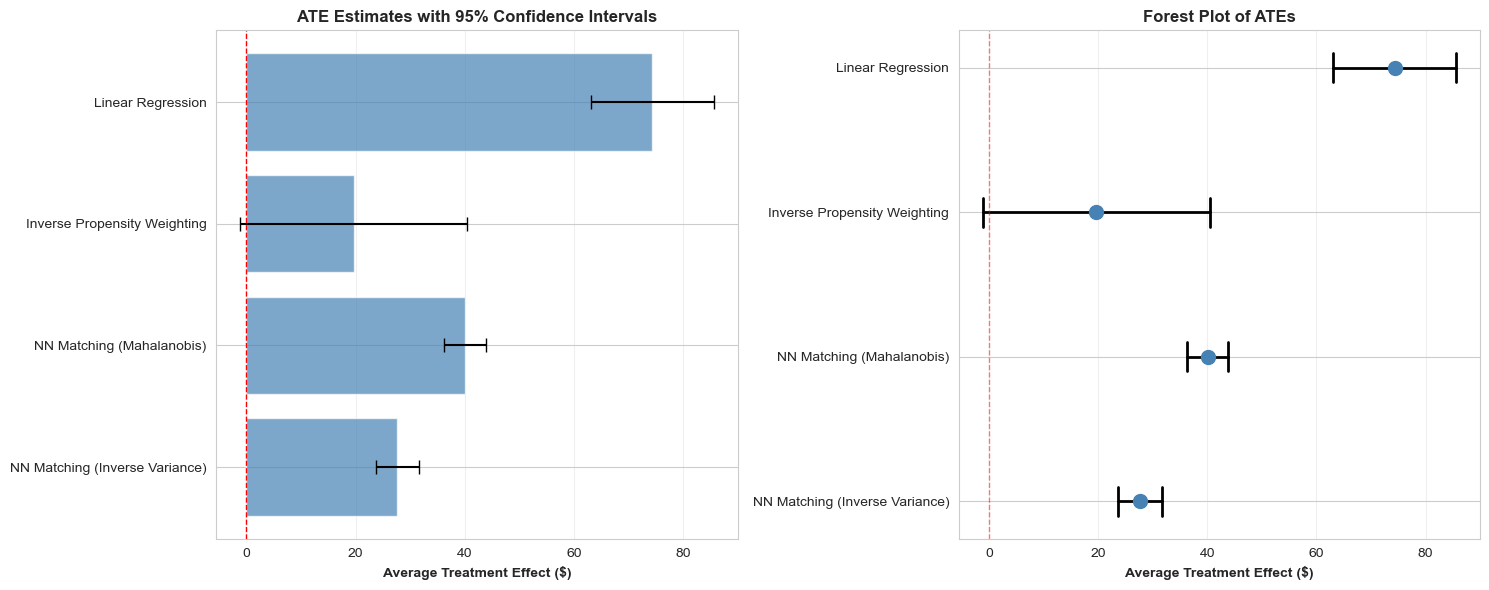


Plot saved to: ../../../data/output/question4_ate_comparison.png


In [14]:
# Question 8: Comparing estimators
print("="*70)
print("QUESTION 4: Comparison of Estimators")
print("="*70)

# Calculate statistics
ate_mean = ate_results['ATE'].mean()
ate_std = ate_results['ATE'].std()
ate_range = ate_results['ATE'].max() - ate_results['ATE'].min()
ate_cv = (ate_std / abs(ate_mean)) * 100 if ate_mean != 0 else np.inf

print(f"\nDescriptive Statistics:")
print(f"  Mean ATE: ${ate_mean:.2f}")
print(f"  Std Dev: ${ate_std:.2f}")
print(f"  Range: ${ate_range:.2f}")
print(f"  Coefficient of Variation: {ate_cv:.2f}%")
print(f"  Min ATE: ${ate_results['ATE'].min():.2f} ({ate_results.loc[ate_results['ATE'].idxmin(), 'Method']})")
print(f"  Max ATE: ${ate_results['ATE'].max():.2f} ({ate_results.loc[ate_results['ATE'].idxmax(), 'Method']})")

# Interpretation
print("\n" + "-"*70)
print("Interpretation:")
print("-"*70)

if ate_cv < 10:
    conclusion = "The results are VERY SIMILAR across methods (CV < 10%)"
    detail = "All four estimators produce nearly identical treatment effects, suggesting robust findings."
elif ate_cv < 25:
    conclusion = "The results are MODERATELY SIMILAR across methods (10% ≤ CV < 25%)"
    detail = "There is some variation across estimators, but they generally agree on the direction and magnitude."
else:
    conclusion = "The results are SUBSTANTIALLY DIFFERENT across methods (CV ≥ 25%)"
    detail = "The estimators produce notably different results, suggesting sensitivity to methodological choices."

print(f"\n{conclusion}")
print(f"{detail}")

# Check if all have same sign
all_positive = (ate_results['ATE'] > 0).all()
all_negative = (ate_results['ATE'] < 0).all()

if all_positive:
    print("\n✓ All estimators agree that treatment INCREASES bids (positive effect)")
elif all_negative:
    print("\n✓ All estimators agree that treatment DECREASES bids (negative effect)")
else:
    print("\n⚠ Estimators disagree on the direction of the effect!")

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart with error bars
ax1.barh(ate_results['Method'], ate_results['ATE'], color='steelblue', alpha=0.7)
ax1.errorbar(ate_results['ATE'], range(len(ate_results)), 
             xerr=1.96*ate_results['SE'], fmt='none', color='black', capsize=5)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax1.set_xlabel('Average Treatment Effect ($)', fontweight='bold')
ax1.set_title('ATE Estimates with 95% Confidence Intervals', fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# Forest plot style
y_pos = np.arange(len(ate_results))
ax2.scatter(ate_results['ATE'], y_pos, s=100, color='steelblue', zorder=3)
for i, row in ate_results.iterrows():
    ax2.plot([row['CI_Lower'], row['CI_Upper']], [i, i], 'k-', linewidth=2, zorder=2)
    ax2.plot([row['CI_Lower'], row['CI_Lower']], [i-0.1, i+0.1], 'k-', linewidth=2)
    ax2.plot([row['CI_Upper'], row['CI_Upper']], [i-0.1, i+0.1], 'k-', linewidth=2)

ax2.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(ate_results['Method'])
ax2.set_xlabel('Average Treatment Effect ($)', fontweight='bold')
ax2.set_title('Forest Plot of ATEs', fontweight='bold', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig("../../../data/output/question4_ate_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: ../../../data/output/question4_ate_comparison.png")

QUESTION 5: ATE with Continuous Covariates

Estimation sample with continuous covariates: 1,976 counties
  Treated: 988
  Control: 988

Covariates used:
  - avg_ffscost (continuous FFS costs)
  - total_benef (total Medicare beneficiaries)

----------------------------------------------------------------------
Re-estimating with continuous covariates...
----------------------------------------------------------------------

1. NN Matching (Inverse Variance): $-22.68 (SE: $3.81)
2. NN Matching (Mahalanobis): $-22.43 (SE: $3.86)
3. Inverse Propensity Weighting: $9.92 (SE: $169.43)
4. Linear Regression: $363.58 (SE: $16.04)

COMPARISON: Quartile-based vs Continuous Covariates
                        Method  ATE_Quartiles  ATE_Continuous  Difference
NN Matching (Inverse Variance)          27.67          -22.68      -50.35
     NN Matching (Mahalanobis)          40.06          -22.43      -62.50
  Inverse Propensity Weighting          19.65            9.92       -9.72
             Linear Reg

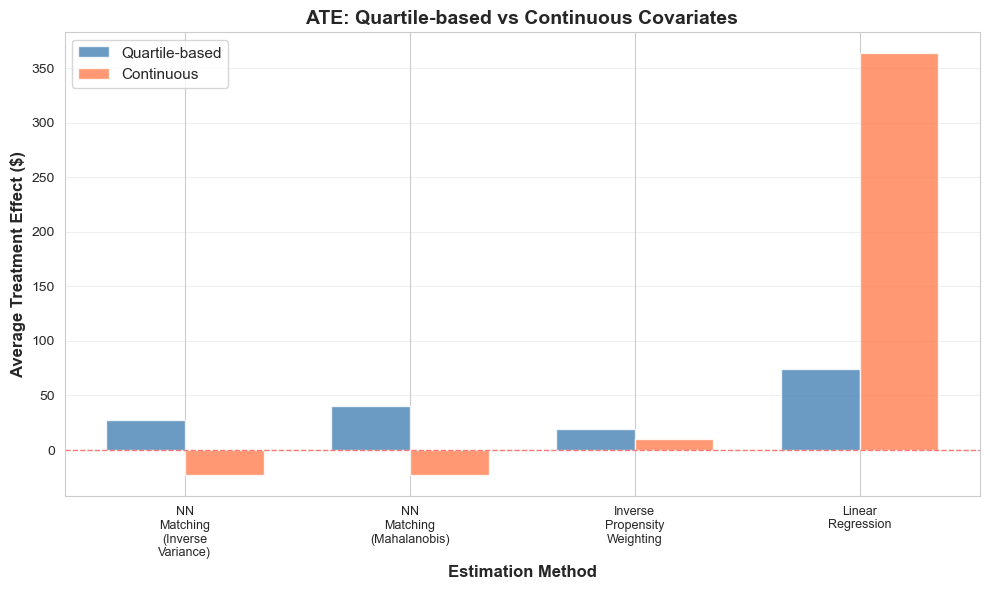


Plot saved to: ../../../data/output/question5_continuous_comparison.png
Results saved to: ../../../data/output/question5_continuous_results.csv


In [15]:
# Question 9: ATE using continuous FFS costs variable
print("="*70)
print("QUESTION 5: ATE with Continuous Covariates")
print("="*70)

# Prepare data with continuous covariates
continuous_data = county_level.dropna(subset=[bid_col, 'avg_ffscost', 'total_benef'])

print(f"\nEstimation sample with continuous covariates: {len(continuous_data):,} counties")
print(f"  Treated: {(continuous_data['treatment']==1).sum():,}")
print(f"  Control: {(continuous_data['treatment']==0).sum():,}")

# Continuous covariates
continuous_covariates = ['avg_ffscost', 'total_benef']

print(f"\nCovariates used:")
print(f"  - avg_ffscost (continuous FFS costs)")
print(f"  - total_benef (total Medicare beneficiaries)")

print("\n" + "-"*70)
print("Re-estimating with continuous covariates...")
print("-"*70)

# Estimate using all four methods
ate_nn_iv_cont, se_nn_iv_cont, n_treated_cont, _ = nearest_neighbor_matching_inverse_variance(
    continuous_data, bid_col, 'treatment', continuous_covariates
)
print(f"\n1. NN Matching (Inverse Variance): ${ate_nn_iv_cont:.2f} (SE: ${se_nn_iv_cont:.2f})")

ate_nn_maha_cont, se_nn_maha_cont, _, _ = nearest_neighbor_matching_mahalanobis(
    continuous_data, bid_col, 'treatment', continuous_covariates
)
print(f"2. NN Matching (Mahalanobis): ${ate_nn_maha_cont:.2f} (SE: ${se_nn_maha_cont:.2f})")

ate_ipw_cont, se_ipw_cont, ps_scores_cont = inverse_propensity_weighting(
    continuous_data, bid_col, 'treatment', continuous_covariates
)
print(f"3. Inverse Propensity Weighting: ${ate_ipw_cont:.2f} (SE: ${se_ipw_cont:.2f})")

ate_reg_cont, se_reg_cont, reg_model_cont = linear_regression_ate(
    continuous_data, bid_col, 'treatment', continuous_covariates
)
print(f"4. Linear Regression: ${ate_reg_cont:.2f} (SE: ${se_reg_cont:.2f})")

# Create comparison table
continuous_results = pd.DataFrame({
    'Method': [
        'NN Matching (Inverse Variance)',
        'NN Matching (Mahalanobis)',
        'Inverse Propensity Weighting',
        'Linear Regression'
    ],
    'ATE_Quartiles': [ate_nn_iv, ate_nn_maha, ate_ipw, ate_reg],
    'ATE_Continuous': [ate_nn_iv_cont, ate_nn_maha_cont, ate_ipw_cont, ate_reg_cont],
    'Difference': [
        ate_nn_iv_cont - ate_nn_iv,
        ate_nn_maha_cont - ate_nn_maha,
        ate_ipw_cont - ate_ipw,
        ate_reg_cont - ate_reg
    ]
})

print("\n" + "="*70)
print("COMPARISON: Quartile-based vs Continuous Covariates")
print("="*70)
print(continuous_results.to_string(index=False))

# Statistical summary
print(f"\nAverage difference across methods: ${continuous_results['Difference'].mean():.2f}")
print(f"Largest difference: ${continuous_results['Difference'].abs().max():.2f}")

# Interpretation
print("\n" + "-"*70)
print("Interpretation:")
print("-"*70)

avg_pct_diff = abs(continuous_results['Difference'].mean() / continuous_results['ATE_Quartiles'].mean() * 100)

if avg_pct_diff < 5:
    print(f"The continuous specification produces VERY SIMILAR results (avg diff: {avg_pct_diff:.1f}%)")
    print("Using continuous vs quartile covariates has minimal impact on the estimates.")
elif avg_pct_diff < 15:
    print(f"The continuous specification produces MODERATELY DIFFERENT results (avg diff: {avg_pct_diff:.1f}%)")
    print("The choice of functional form has some impact on the treatment effect estimates.")
else:
    print(f"The continuous specification produces SUBSTANTIALLY DIFFERENT results (avg diff: {avg_pct_diff:.1f}%)")
    print("The estimates are sensitive to how we model the relationship with FFS costs.")

# Visual comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(continuous_results))
width = 0.35

rects1 = ax.bar(x - width/2, continuous_results['ATE_Quartiles'], width, 
                label='Quartile-based', color='steelblue', alpha=0.8)
rects2 = ax.bar(x + width/2, continuous_results['ATE_Continuous'], width, 
                label='Continuous', color='coral', alpha=0.8)

ax.set_xlabel('Estimation Method', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Treatment Effect ($)', fontweight='bold', fontsize=12)
ax.set_title('ATE: Quartile-based vs Continuous Covariates', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([m.replace(' ', '\n') for m in continuous_results['Method']], fontsize=9)
ax.legend(fontsize=11)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("../../../data/output/question5_continuous_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Save results
continuous_results.to_csv("../../../data/output/question5_continuous_results.csv", index=False)

print(f"\nPlot saved to: ../../../data/output/question5_continuous_comparison.png")
print(f"Results saved to: ../../../data/output/question5_continuous_results.csv")

In [16]:
# Save county-level analysis data
county_level.to_csv("../../../data/output/county_analysis_2018.csv", index=False)

# Save analysis data with all variables
analysis_data.to_csv("../../../data/output/analysis_data_2018_full.csv", index=False)

# Create summary document
summary_stats = {
    'Total_Counties': len(county_level),
    'Competitive_Markets': (county_level['treatment']==0).sum(),
    'Uncompetitive_Markets': (county_level['treatment']==1).sum(),
    'Avg_Bid_Overall': county_level[bid_col].mean(),
    'Avg_FFS_Cost': county_level['avg_ffscost'].mean(),
    'HHI_33rd_Percentile': hhi_33,
    'HHI_66th_Percentile': hhi_66,
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv("../../../data/output/summary_statistics.csv", index=False)

print("="*70)
print("ALL RESULTS SAVED")
print("="*70)
print("\nFiles created:")
print("  1. county_analysis_2018.csv - County-level data with all variables")
print("  2. analysis_data_2018_full.csv - Full plan-level data")
print("  3. question1_avg_bid.png - Q1 visualization")
print("  4. question2_bid_by_quartile.png - Q2 visualization")
print("  5. question2_bid_table.csv - Q2 detailed table")
print("  6. question3_ate_results.csv - Q3 ATE estimates")
print("  7. question4_ate_comparison.png - Q4 visualization")
print("  8. question5_continuous_comparison.png - Q5 visualization")
print("  9. question5_continuous_results.csv - Q5 detailed results")
print(" 10. summary_statistics.csv - Overall summary stats")
print("="*70)

ALL RESULTS SAVED

Files created:
  1. county_analysis_2018.csv - County-level data with all variables
  2. analysis_data_2018_full.csv - Full plan-level data
  3. question1_avg_bid.png - Q1 visualization
  4. question2_bid_by_quartile.png - Q2 visualization
  5. question2_bid_table.csv - Q2 detailed table
  6. question3_ate_results.csv - Q3 ATE estimates
  7. question4_ate_comparison.png - Q4 visualization
  8. question5_continuous_comparison.png - Q5 visualization
  9. question5_continuous_results.csv - Q5 detailed results
 10. summary_statistics.csv - Overall summary stats


In [ ]:
# Question 10: Reflection on Working with Medicare Advantage Data
print("="*70)
print("QUESTION 6: Reflection on Working with Medicare Advantage Data")
print("="*70)

# Template for your reflection
reflection = """
MY EXPERIENCE WORKING WITH THESE DATA:

[Write a few sentences about your overall experience. For example:
""]

ONE THING I LEARNED:

[Write what you learned. For example:
""]

ONE THING THAT AGGRAVATED/SURPRISED ME:

[Write what surprised or frustrated you. For example:
"I was surprised by how much the treatment effects varied depending on whether 
I used FFS cost quartiles versus continuous FFS costs. I initially expected 
the results to be more stable across specifications. Additionally, the data 
cleaning process was more time-intensive than anticipated, particularly 
dealing with missing values and ensuring proper merges across FIPS and SSA 
county codes."]

"""

print(reflection)

# Save to file
with open("../../../data/output/question6_reflection.txt", "w") as f:
    f.write(reflection)

print("\n" + "="*70)
print("Reflection template saved to: ../../../data/output/question6_reflection.txt")
print("Please edit this file with your own responses!")
print("="*70)